In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from Manage_data.db_manager import get_data

In [22]:
df = get_data('META', granularity='daily')
df.drop(columns=['Title'], inplace=True)
df.head()

Adding Symbol: META
entry already exists or no title


,Date,Open,High,Low,Close,Adj_close,Volume
0,2025-02-28,658.04,669.63,642.60,668.20,668.20,17517800
1,2025-02-27,682.45,688.65,657.57,658.24,658.24,12500000
2,2025-02-26,659.65,683.01,658.00,673.70,673.70,14488700
3,2025-02-25,665.97,668.00,641.86,657.50,657.50,20579700
4,2025-02-24,686.28,687.27,662.45,668.13,668.13,15677000


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       3214 non-null   datetime64[ns]
 1   Open       3214 non-null   float64       
 2   High       3214 non-null   float64       
 3   Low        3214 non-null   float64       
 4   Close      3214 non-null   float64       
 5   Adj_close  3214 non-null   float64       
 6   Volume     3214 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 175.9 KB


In [24]:
train_set = df.iloc[:, 1:2].values
print(train_set)
print(train_set.shape)

[[658.04]
 [682.45]
 [659.65]
 ...
 [ 32.61]
 [ 36.53]
 [ 42.05]]
(3214, 1)


In [25]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range= (0,1))
scaled_train_set = scaler.fit_transform(train_set)
scaled_train_set

array([[0.89140851],
       [0.92540952],
       [0.8936511 ],
       ...,
       [0.02023902],
       [0.02569924],
       [0.03338812]], shape=(3214, 1))

In [26]:
X_train = []
y_train = []
for i in range(30, 1200):
    X_train.append(scaled_train_set[i-30:i, 0])
    y_train.append(scaled_train_set[i, 0])
X_train = np.array(X_train)
y_train = np.array(y_train)
print(X_train)
print(X_train.shape)
print(y_train)
print(y_train.shape)

[[0.89140851 0.92540952 0.8936511  ... 0.83539949 0.84406341 0.82658235]
 [0.92540952 0.8936511  0.90245431 ... 0.84406341 0.82658235 0.82478549]
 [0.8936511  0.90245431 0.93074437 ... 0.82658235 0.82478549 0.81762592]
 ...
 [0.30648262 0.3082934  0.30042345 ... 0.28850011 0.28724649 0.29389068]
 [0.3082934  0.30042345 0.30772231 ... 0.28724649 0.29389068 0.30879485]
 [0.30042345 0.30772231 0.29309672 ... 0.29389068 0.30879485 0.29728939]]
(1170, 30)
[0.82478549 0.81762592 0.82045353 ... 0.30879485 0.29728939 0.30176064]
(1170,)


In [27]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

X_train.shape

(1170, 30, 1)

Epoch [10/100], Loss: 0.1852
Epoch [20/100], Loss: 0.1763
Epoch [30/100], Loss: 0.1675
Epoch [40/100], Loss: 0.1596
Epoch [50/100], Loss: 0.1516
Epoch [60/100], Loss: 0.1446
Epoch [70/100], Loss: 0.1386
Epoch [80/100], Loss: 0.1320
Epoch [90/100], Loss: 0.1258
Epoch [100/100], Loss: 0.1205


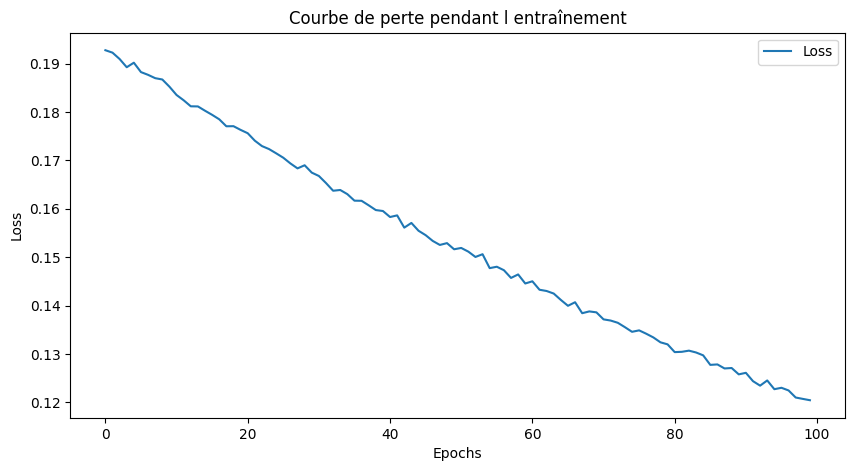

 Analyse des performances : MAE = 0.2966, MSE = 0.1197, RMSE = 0.3460


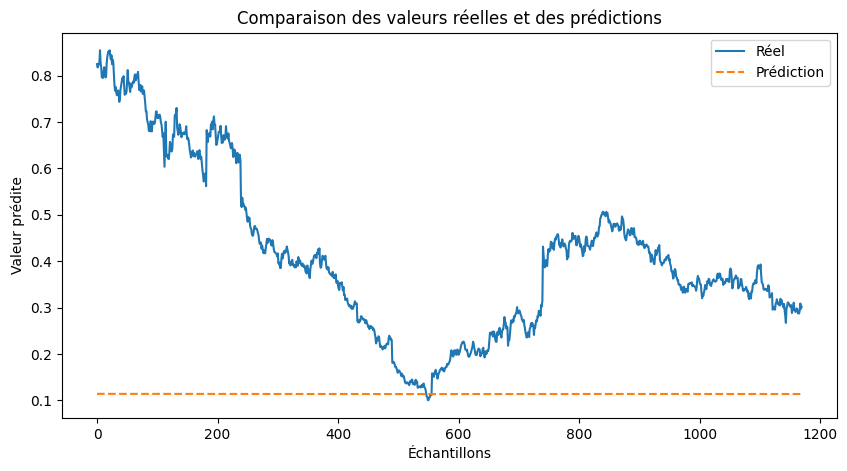

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Définition du modèle LSTM avec PyTorch
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=4, dropout=0.2, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = self.dropout(lstm_out[:, -1, :])  # Prendre la dernière sortie temporelle
        output = self.fc(lstm_out)
        return output

# Initialisation du modèle
input_size = 1
model = LSTMModel(input_size=input_size)

# Définition de la fonction de perte et de l'optimiseur
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

# Convertir les données numpy en tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

# Ajouter une dimension si nécessaire pour correspondre au format (batch_size, seq_len, input_size)
if X_train_tensor.dim() == 2:
    X_train_tensor = X_train_tensor.unsqueeze(-1)
if y_train_tensor.dim() == 1:
    y_train_tensor = y_train_tensor.unsqueeze(-1)

# Entraînement du modèle
num_epochs = 100
batch_size = 32
losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Analyse des résultats
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Courbe de perte pendant l entraînement')
plt.legend()
plt.show()

# Prédictions sur les données d'entraînement
model.eval()
with torch.no_grad():
    predictions = model(X_train_tensor).numpy()
    y_train_np = y_train_tensor.numpy()

# Calcul des erreurs
mae = mean_absolute_error(y_train_np, predictions)
mse = mean_squared_error(y_train_np, predictions)
rmse = np.sqrt(mse)
print(f' Analyse des performances : MAE = {mae:.4f}, MSE = {mse:.4f}, RMSE = {rmse:.4f}')

# Visualisation des prédictions vs valeurs réelles
plt.figure(figsize=(10, 5))
plt.plot(y_train_np, label='Réel')
plt.plot(predictions, label='Prédiction', linestyle='dashed')
plt.xlabel('Échantillons')
plt.ylabel('Valeur prédite')
plt.title('Comparaison des valeurs réelles et des prédictions')
plt.legend()
plt.show()
